# COVID-19 Health Care System Simulation

### Introduction

Our purpose is to predict whether the health care system will collapse because of unsufficient intensive care unit or not in Turkey. Firstly, we try to predict how many cases there will be in next days if we take necessary precautions or we do not. Then, we simulate a health care system by using these predictions and calculate necessary statistics like occupancy rate of intensive care unit, number of recovered and died people day by day. Lastly, we visualize the result of our simulation. This notebook explains the technical details of our project. Non technical details can be found in the report.

### Import Libraries

Import necessary libraries and read the `total_cases.csv` file which contains number of cases in countries each day.

In [1]:
import heapq
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
from keras.optimizers import Adam
%matplotlib inline

df = pd.read_csv("total_cases.csv")
df.head()

Using TensorFlow backend.


,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2020-01-01,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,2020-01-02,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,2020-01-03,44,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,2020-01-04,44,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


There are totally 110 days data starting from date 2019-12-31.

In [2]:
len(df)

110

### Preprocess the Dataframe

In [3]:
df.fillna(method='pad', inplace = True) # If there is no new data reported that day, take it is equal to the previous day data.
df.fillna(0, inplace = True) # If there is no data reported at all, fill them with 0.
df.drop(df.columns[[0, 1]], axis=1, inplace = True) # Drop date and world data statistics. 
df = df.astype("int64") # Convert all the data in the dataframe to 64 bytes int.

In [4]:
df.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Prepare Input and Output Data

Create input and output data from the dataframe. Each input record has 8 attributes. First of them is mean of other seven attributes and other seven attributes are the data at previous 7 days respectively. Output is the next day which want to be predicted.

In [5]:
how_many_previous = 7
X = []
y = []

for column in df.columns:
    for i in range(len(df) - how_many_previous):
        if ((0 != df[column][i])) and (df[column][i: i+how_many_previous].sum()+df[column][i+how_many_previous] != 0):
            X.append(np.concatenate([np.array([np.array(df[column][i: i+how_many_previous]).mean()]), np.array(df[column][i: i+how_many_previous])]))
            y.append(df[column][i+how_many_previous])

X = np.array(X)
y = np.array(y)

Normalize the input and output data so that machine learning models can perform better.

In [6]:
X_max = X.max()
X = X / X_max
y = y / X_max

There are totally 7638 record in our input data.

In [7]:
len(X)

7638

### Model Training

Split train and test data and create an example case to see how models work.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
example = np.array([100, 150, 200, 250, 300 ,350, 400])

Train 7 different machine learning algorithms to see which one performs best. One can see the r2 score, mse and mae statistics for train and test set for each algorithm and result of prediction. Intercept and coefficients of linear models can also be found below. Lastly, we do a cross validation to see which one performs best and we compare models according to 3 metrics(mean squared error, mean absolute error and r2 score). Linear regression model performs best, so we continue with it. 

In [9]:
lin_model = LinearRegression().fit(X_train, y_train)
print("Linear regression model")
print("r2 score: ", lin_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, lin_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, lin_model.predict(X_test)))
print("intercept: ", lin_model.intercept_,", coefficients: " , lin_model.coef_)
print("prediction: ", lin_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(lin_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Linear regression model
r2 score:  0.9998738804815911
mse:  3.3712933456972063e-07
mae:  0.00013637263055182346
intercept:  2.446125525323601e-05 , coefficients:  [ 0.12437484 -0.1409165   0.05542508 -0.07711147 -0.05469164  0.01851373
 -0.47681573  1.5462204 ]
prediction:  469.7989847140197
cross validation r2 score:  0.9995045903133668
cross validation mse:  3.212731840350314e-07
cross validation mae:  0.00011916720698311011


In [10]:
lasso_model = Lasso().fit(X_train, y_train)
print("Lasso regression model")
print("r2 score: ", lasso_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, lasso_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, lasso_model.predict(X_test)))
print("intercept: ", lasso_model.intercept_,", coefficients: " , lasso_model.coef_)
print("prediction: ", lasso_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(lasso_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Lasso regression model
r2 score:  -0.0006542730612044689
mse:  0.0026748429859841448
mae:  0.012615829658239059
intercept:  0.0069838394494523 , coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]
prediction:  4688.467921440262
cross validation r2 score:  -0.3162502826410058
cross validation mse:  0.001732927331714881
cross validation mae:  0.011916403367005555


In [11]:
ridge_model = Ridge().fit(X_train, y_train)
print("Ridge regression model")
print("r2 score: ", ridge_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, ridge_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, ridge_model.predict(X_test)))
print("intercept: ", ridge_model.intercept_,", coefficients: " , ridge_model.coef_)
print("prediction: ", ridge_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(ridge_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Ridge regression model
r2 score:  0.9907930006229045
mse:  2.4611175276795684e-05
mae:  0.0010689833966578478
intercept:  0.0002764342024009058 , coefficients:  [0.1443327  0.04289343 0.07161049 0.10334875 0.13929667 0.17713467
 0.21703231 0.2590126 ]
prediction:  524.8936052701367
cross validation r2 score:  0.9799652740462506
cross validation mse:  5.5010097808540445e-05
cross validation mae:  0.0013011716214356823


In [12]:
elastic_model = ElasticNet().fit(X_train, y_train)
print("Elastic net regression model")
print("r2 score: ", elastic_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, elastic_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, elastic_model.predict(X_test)))
print("intercept: ", elastic_model.intercept_,", coefficients: " , elastic_model.coef_)
print("prediction: ", elastic_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(elastic_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Elastic net regression model
r2 score:  -0.0006542730612044689
mse:  0.0026748429859841448
mae:  0.012615829658239059
intercept:  0.0069838394494523 , coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]
prediction:  4688.467921440262
cross validation r2 score:  -0.3162502826410058
cross validation mse:  0.001732927331714881
cross validation mae:  0.011916403367005555


In [13]:
forest_model = RandomForestRegressor().fit(X_train, y_train)
print("Random forest regression model")
print("r2 score: ", forest_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, forest_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, forest_model.predict(X_test)))
print("prediction: ", forest_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(forest_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

C:\Users\umutd\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random forest regression model
r2 score:  0.9968979929340708
mse:  8.29195663892015e-06
mae:  0.00041920316931145076
prediction:  527.4162064712012
cross validation r2 score:  0.9180825540907224
cross validation mse:  0.0005323807519982909
cross validation mae:  0.001316946509577712


In [14]:
neighbor_model = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
print("K nearest neighbors regression model")
print("r2 score: ", neighbor_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, neighbor_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, neighbor_model.predict(X_test)))
print("prediction: ", neighbor_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(neighbor_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

K nearest neighbors regression model
r2 score:  0.8279293577172153
mse:  0.00045996101050551545
mae:  0.0015764354399938215
prediction:  492.3500000000001
cross validation r2 score:  0.9036950650199784
cross validation mse:  0.0006202449174781585
cross validation mae:  0.0014914704670750134


We train a neural network to see how it performs. However, it does not perform very well compared to linear regression model and it needs so much hyperparameter tuning. So, we do not continue with neural network models.

In [15]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=8))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1))
optimizer = Adam(lr = 0.00005)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[r2_score, "mae"])

model.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = [X_test, y_test])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 6110 samples, validate on 1528 samples
Epoch 1/200
6110/6110 [==============================] - 1s 184us/step - loss: 0.0018 - r2_score: -0.4910 - mean_absolute_error: 0.0074 - val_loss: 0.0030 - val_r2_score: -0.8534 - val_mean_absolute_error: 0.0077
Epoch 2/200
6110/6110 [==============================] - 0s 77us/step - loss: 0.0012 - r2_score: -0.1025 - mean_absolute_error: 0.0052 - val_loss: 0.0022 - val_r2_score: 0.3221 - val_mean_absolute_error: 0.0056
Epoch 3/200
6110/6110 [==============================] - 0s 70us/step - loss: 8.6169e-04 - r2_score: 0.6033 - mean_absolute_error: 0.0038 - val_loss: 0.0017 - val_r2_score: 0.4981 - val_mean_absolute_error: 0.0045
Epoch 4/200
6110/6110 [==============================] - 0s 78us/step - loss: 6.5323e-04 - r2_score: 0.7184 - mean_absolute_error: 0.0027 - val_loss: 0.0014 - val_r2_score: 0.9268 - val_mean_abs

6110/6110 [==============================] - 0s 81us/step - loss: 8.8953e-07 - r2_score: 0.9688 - mean_absolute_error: 3.2888e-04 - val_loss: 1.0948e-06 - val_r2_score: 0.9180 - val_mean_absolute_error: 5.2345e-04
Epoch 36/200
6110/6110 [==============================] - 0s 79us/step - loss: 8.2808e-07 - r2_score: 0.9809 - mean_absolute_error: 3.2176e-04 - val_loss: 9.8786e-07 - val_r2_score: 0.9953 - val_mean_absolute_error: 2.2684e-04
Epoch 37/200
6110/6110 [==============================] - 1s 83us/step - loss: 8.3446e-07 - r2_score: 0.9758 - mean_absolute_error: 3.1814e-04 - val_loss: 1.4511e-06 - val_r2_score: 0.9925 - val_mean_absolute_error: 2.7075e-04
Epoch 38/200
6110/6110 [==============================] - 0s 81us/step - loss: 8.4150e-07 - r2_score: 0.9853 - mean_absolute_error: 3.0459e-04 - val_loss: 1.3755e-06 - val_r2_score: 0.9699 - val_mean_absolute_error: 3.9608e-04
Epoch 39/200
6110/6110 [==============================] - 0s 76us/step - loss: 8.1441e-07 - r2_score: 0.9

6110/6110 [==============================] - 0s 80us/step - loss: 7.4601e-07 - r2_score: 0.9697 - mean_absolute_error: 2.9057e-04 - val_loss: 9.1098e-07 - val_r2_score: 0.9726 - val_mean_absolute_error: 3.6474e-04
Epoch 108/200
6110/6110 [==============================] - 0s 81us/step - loss: 7.9005e-07 - r2_score: 0.9813 - mean_absolute_error: 3.0929e-04 - val_loss: 1.3001e-06 - val_r2_score: 0.9954 - val_mean_absolute_error: 2.4284e-04
Epoch 109/200
6110/6110 [==============================] - 1s 82us/step - loss: 7.3720e-07 - r2_score: 0.9821 - mean_absolute_error: 2.9063e-04 - val_loss: 8.2635e-07 - val_r2_score: 0.9890 - val_mean_absolute_error: 2.8865e-04
Epoch 110/200
6110/6110 [==============================] - 1s 87us/step - loss: 7.8202e-07 - r2_score: 0.9826 - mean_absolute_error: 2.9428e-04 - val_loss: 9.4231e-07 - val_r2_score: 0.9955 - val_mean_absolute_error: 2.1686e-04
Epoch 111/200
6110/6110 [==============================] - 1s 86us/step - loss: 7.3605e-07 - r2_score:

Epoch 143/200
6110/6110 [==============================] - 0s 76us/step - loss: 7.4655e-07 - r2_score: 0.9804 - mean_absolute_error: 2.7402e-04 - val_loss: 9.6823e-07 - val_r2_score: 0.9737 - val_mean_absolute_error: 3.6412e-04
Epoch 144/200
6110/6110 [==============================] - 0s 69us/step - loss: 7.3569e-07 - r2_score: 0.9845 - mean_absolute_error: 2.8739e-04 - val_loss: 1.0881e-06 - val_r2_score: 0.9850 - val_mean_absolute_error: 3.2024e-04
Epoch 145/200
6110/6110 [==============================] - 0s 80us/step - loss: 7.1568e-07 - r2_score: 0.9830 - mean_absolute_error: 2.6908e-04 - val_loss: 8.5932e-07 - val_r2_score: 0.9500 - val_mean_absolute_error: 4.3564e-04
Epoch 146/200
6110/6110 [==============================] - 0s 75us/step - loss: 7.4457e-07 - r2_score: 0.9833 - mean_absolute_error: 3.1605e-04 - val_loss: 8.3886e-07 - val_r2_score: 0.9303 - val_mean_absolute_error: 4.8326e-04
Epoch 147/200
6110/6110 [==============================] - 0s 81us/step - loss: 7.5625e-

Epoch 179/200
6110/6110 [==============================] - 0s 82us/step - loss: 7.3643e-07 - r2_score: 0.9567 - mean_absolute_error: 2.8932e-04 - val_loss: 1.1026e-06 - val_r2_score: 0.9882 - val_mean_absolute_error: 2.9388e-04
Epoch 180/200
6110/6110 [==============================] - 0s 73us/step - loss: 6.9868e-07 - r2_score: 0.9838 - mean_absolute_error: 2.9143e-04 - val_loss: 7.5210e-07 - val_r2_score: 0.9908 - val_mean_absolute_error: 2.6442e-04
Epoch 181/200
6110/6110 [==============================] - 0s 79us/step - loss: 7.0789e-07 - r2_score: 0.9784 - mean_absolute_error: 2.9334e-04 - val_loss: 1.4597e-06 - val_r2_score: 0.9671 - val_mean_absolute_error: 4.1177e-04
Epoch 182/200
6110/6110 [==============================] - 0s 77us/step - loss: 7.7667e-07 - r2_score: 0.9679 - mean_absolute_error: 3.3691e-04 - val_loss: 1.3890e-06 - val_r2_score: 0.9647 - val_mean_absolute_error: 4.0774e-04
Epoch 183/200
6110/6110 [==============================] - 0s 75us/step - loss: 7.1179e-

Train a linear regression model with full input and output data to calculate the number of cases in next days in Turkey if we take precautions and behave like an average world country.

In [15]:
lin_model = LinearRegression().fit(X, y)

### Prediction for Average Scenario

Our model produces output regarding to the previous 7 days and their mean value. When we train our model with the data for all countries, our machine learning model learns the types of trends from 7 days and predicts the next day. When we give 7 total cases of Turkey, model finds the trend in Turkey and predict next total case in Turkey by using this trend information.

Make predictions given last 7 days total cases.

In [16]:
future_data = [47029, 52167, 56956, 61049, 65111, 69392, 74193]

def future(future_dat):
    future_dat.append(lin_model.predict([([np.mean(future_dat[-7:])]+ future_dat[-7:])/X_max])[0]*X_max)
    return future_dat

for i in range(57):
    future_data = future(future_data)

for i in range(len(future_data) - 1):
    if future_data[i+1] < future_data[i]:
        future_data = future_data[:i+1]
        break

future_data

[47029,
 52167,
 56956,
 61049,
 65111,
 69392,
 74193,
 79029.59231308059,
 83936.6215743165,
 88817.73030843295,
 93678.18426987696,
 98525.95298294401,
 103408.69175021158,
 108286.1891322415,
 113147.4944989039,
 117967.45491344712,
 122725.86500406431,
 127403.19925547752,
 131987.68770431704,
 136459.8573861168,
 140801.29557912936,
 144991.44176465363,
 149008.90770782754,
 152831.35246620936,
 156436.81297799625,
 159802.25058257216,
 162904.1798891971,
 165718.4358043573,
 168220.2544266266,
 170384.2671595157,
 172184.7221679798,
 173595.4162626851,
 174589.7913088724,
 175140.97152512474,
 175221.82197153816]

Calculate daily cases in order to give the simulation.

In [17]:
daily_cases = []
for i in range(7, len(future_data)):
    daily_cases.append(future_data[i]-future_data[i-1])
daily_cases        

[4836.5923130805895,
 4907.029261235904,
 4881.108734116453,
 4860.453961444015,
 4847.768713067053,
 4882.738767267569,
 4877.49738202992,
 4861.305366662404,
 4819.9604145432095,
 4758.410090617195,
 4677.334251413209,
 4584.488448839518,
 4472.169681799773,
 4341.438193012553,
 4190.146185524267,
 4017.465943173913,
 3822.444758381811,
 3605.4605117868923,
 3365.4376045759127,
 3101.929306624952,
 2814.2559151601745,
 2501.8186222693184,
 2164.012732889096,
 1800.4550084641087,
 1410.694094705279,
 994.3750461873133,
 551.1802162523381,
 80.85044641341665]

### Average Case Simulation

Give daily cases to the simulation and simulation will produce some output. This is a basic Jackson Network Simulation. The Queueing Model of this simulation can be found on our report.

The first queue in the system represents the COVID positive patients in Turkey. In this simulation we assume that the arrival process of the patients to the hospital is a Poisson process. Because in the estimation we make, we take into account the effects between 2 patients. So in the simulation, probability of a new COVID positive patient is independet from other patients. Because the time between 2 poisson processes is an exponential distribution random variable, we use exponential distribution.

Other interarrival time values are founded from data sources that can be found in the [`README.md`](https://github.com/HUmutOzdemir/COVIDDatathon/blob/master/README.md) file.

In [18]:
# Duration of the simulation(days)
duration = 57
# Input patient list
coming_patient_list = daily_cases
# Number of Intense Care used by COVID-19
num_used_COVID = 1854
# Length of day (in hours)
length_of_day = 24
# Coming patient rate of the first day
lambda_ = coming_patient_list[0]/length_of_day
# First interarrival time of the patient
interarrival_time=np.random.exponential(scale=1/lambda_)

In [19]:
event_queue = []
# Add first 2 events
heapq.heappush(event_queue,(interarrival_time,"Arrival")) 
heapq.heappush(event_queue,(24,"Day End"))
heapq.heappush(event_queue,(duration*24,"Finish"))

# Percantage of Patient Who Goes Intense Care
intensecare_percent = 0.061
# Percentage of death of person who goes intensecare unit
death_percentage = 0.51

# Guassian coefficiants of t_home Guassian Random Variable
t_home_coef = (84,36)
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_intensecare_coef = (756,252) 
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_health_coef = (216,12)

In [20]:
# Add Current Intense care Events to Event queue
for i in range(num_used_COVID):
    # Create Intense Care Time
    # We assume that every patient in the ICU was come here after the 12th day which is the mean value of goint the the ICU
    # Also because we cannot find any data, we assume that these days have equal probability
    t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
    # Add Intense Care Event to Event Queue
    heapq.heappush(event_queue,(t_intensecare,"Intense Care"))

# Intense Care Unit Stats
daily_intensecare_increase=0
max_num_of_intensecare = 25446
intensecare_fullness = 0.595
intensecare_used = max_num_of_intensecare * intensecare_fullness

day_counter = 0

# Output List
output_list = []

# Daily statistics
num_of_arrival = 0
num_of_death = 0
num_of_healthy = 0
num_of_noncared = 0

In [21]:
while event_queue:
    # Pop the event
    current_event = heapq.heappop(event_queue)
    if current_event[1] == "Day End":
        day_counter += 1
        if day_counter < len(coming_patient_list):
            # Add new intense care units
            max_num_of_intensecare += daily_intensecare_increase
            # Calculate next lambda
            lambda_=coming_patient_list[day_counter]/length_of_day
        # Add other day end event
        heapq.heappush(event_queue,(current_event[0]+24,"Day End"))
        # Generate Output
        output_list.append((num_of_arrival,num_of_healthy,num_of_death,(intensecare_used/max_num_of_intensecare)*100,num_of_noncared))
        # Make daily stats zero
        num_of_arrival = 0
        num_of_death = 0
        num_of_healthy = 0
        num_of_noncared = 0
        continue
    if current_event[1] == "Arrival":
        # Increase number of arrivals
        num_of_arrival += 1
        # Create Rest Time in Home-Hospital
        t_home = np.random.normal(loc=t_home_coef[0],scale=t_home_coef[1])
        # Add Home-Hospipal Event to Event Queue
        heapq.heappush(event_queue,(current_event[0]+t_home,"Home-Hospital"))
        if day_counter < len(coming_patient_list):
            # Create new interarrival time
            interarrival_time=np.random.exponential(scale=1/lambda_)
            # Add new Arrival Event to the Event Queue
            heapq.heappush(event_queue,(current_event[0]+interarrival_time,"Arrival"))
        continue
    if current_event[1] =="Home-Hospital":
        # Check the patient will go intense care unit or not
        if intensecare_percent > np.random.uniform(0,1):
            if intensecare_used < max_num_of_intensecare:
                # Use intense care unit
                intensecare_used += 1
                # Create Intense Care Time
                t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
                # Add Intense Care Event to Event Queue
                heapq.heappush(event_queue,(current_event[0]+t_intensecare,"Intense Care"))
            else:
                # Increase number of non cared patients
                num_of_noncared += 1
                # Add Death Out Event to the Event Queue 
                heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Intense Care":
        # Decrease used intense care unit
        intensecare_used -= 1
        # Check the patient will die or not
        if death_percentage > np.random.uniform(0,1):
            # Add Death Out Event to the Event Queue 
            heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Healthy-Out":
        # Increase number of healthy
        num_of_healthy += 1
        continue
    if current_event[1] == "Death-Out":
        #Increase number of death
        num_of_death += 1
        continue
    if current_event[1] == "Finish":
        break

In [22]:
output_list

[(4846, 0, 2, 59.51964945374518, 0),
 (4969, 0, 0, 59.63361628546726, 0),
 (4904, 0, 2, 59.92835809164505, 0),
 (4724, 0, 1, 60.46675312426314, 0),
 (4808, 0, 1, 61.28810029081191, 0),
 (4878, 0, 2, 62.21948439833373, 0),
 (4858, 2, 5, 63.37880216929969, 0),
 (4830, 7, 2, 64.49096125127721, 0),
 (4818, 18, 6, 65.7052974927297, 0),
 (4793, 150, 3, 66.77815766721685, 0),
 (4749, 484, 0, 67.88245696769629, 0),
 (4568, 1202, 7, 69.00640572192093, 0),
 (4442, 2277, 10, 69.965299064686, 0),
 (4357, 3371, 17, 71.06173858366736, 0),
 (4176, 4149, 8, 72.13066886740548, 0),
 (4024, 4469, 20, 73.07777253792345, 0),
 (3811, 4524, 22, 73.99736697319814, 0),
 (3561, 4483, 27, 74.89338206397862, 0),
 (3408, 4553, 26, 75.60862218030339, 0),
 (3049, 4587, 20, 76.41031989310697, 0),
 (2872, 4554, 29, 77.02338284995676, 0),
 (2505, 4475, 26, 77.5971468993162, 0),
 (2137, 4408, 36, 77.92725772223532, 0),
 (1801, 4304, 43, 78.25736854515443, 0),
 (1373, 4259, 59, 78.44993319185726, 0),
 (1009, 4139, 52, 78

In [23]:
healthy_patient_nums = [7089]
death_patient_nums = [1643]
intense_care_percets = []
non_ICU_nums = [0]
for output in output_list:
    healthy_patient_nums.append(output[1] + healthy_patient_nums[len(healthy_patient_nums)-1])
    death_patient_nums.append(output[2] + death_patient_nums[len(death_patient_nums)-1])
    intense_care_percets.append(output[3])
    non_ICU_nums.append(output[4] + non_ICU_nums[len(non_ICU_nums)-1])

### Average Case Plots

Plot total cases vs day graph to see results of model clearly.

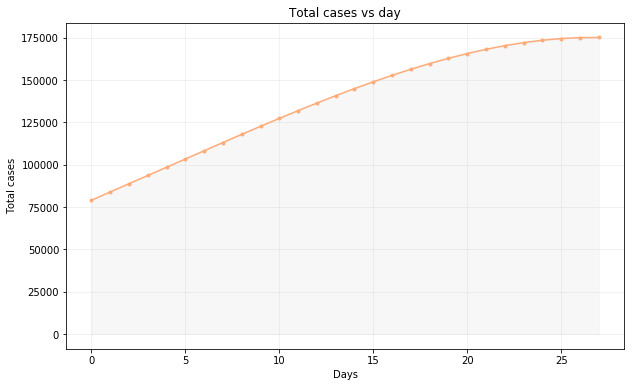

In [24]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(future_data)-7), future_data[7:], color="black", alpha=0.02)
plt.fill_between(range(len(future_data)-7), future_data[7:], color="black", alpha=0.01)
plt.plot(range(len(future_data)-7), future_data[7:],".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("Total cases")
plt.title("Total cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot new cases vs day graph to see results of model clearly.

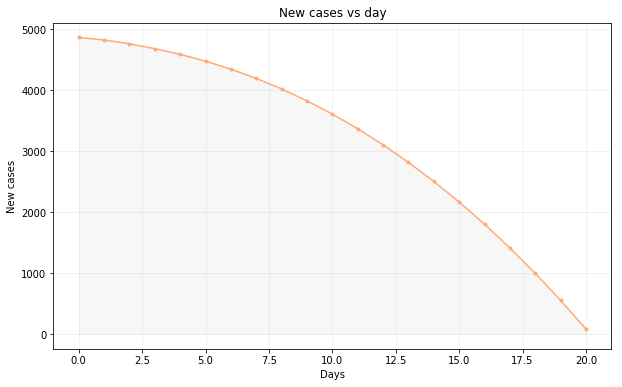

In [25]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.02)
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.01)
plt.plot(range(len(daily_cases)-7), daily_cases[7:],".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("New cases")
plt.title("New cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of healthy covid-19 patients vs day graph to see results of simulation clearly.

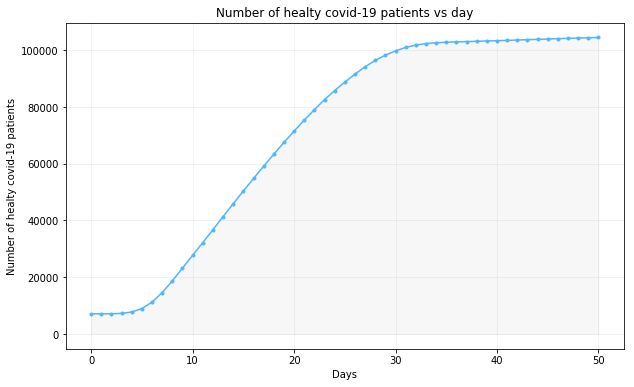

In [26]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between( range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:],".-" , color="#4FB7FF", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of healty covid-19 patients")
plt.title("Number of healty covid-19 patients vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of deaths vs day graph to see results of simulation clearly.

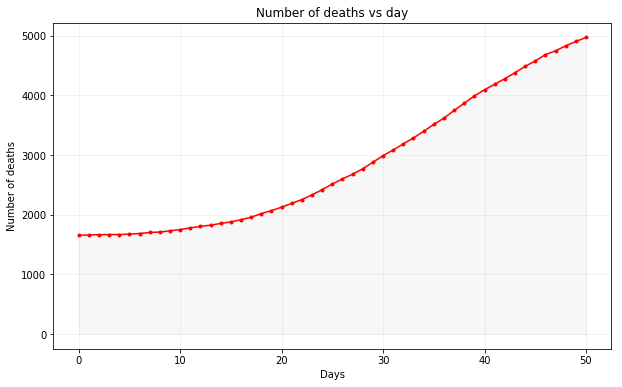

In [27]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(death_patient_nums)-7), death_patient_nums[7:], ".-" , color="red", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.title("Number of deaths vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of intense care percentage vs day graph to see results of simulation clearly.

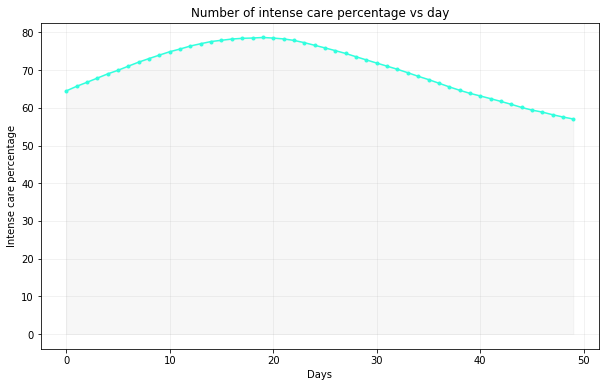

In [28]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.02)
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.01)
plt.plot(range(len(intense_care_percets)-7), intense_care_percets[7:], ".-" , color="#31FFDE", alpha=1)
plt.xlabel("Days")
plt.ylabel("Intense care percentage")
plt.title("Number of intense care percentage vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of patients which can not apply ICU vs day graph to see results of simulation clearly.

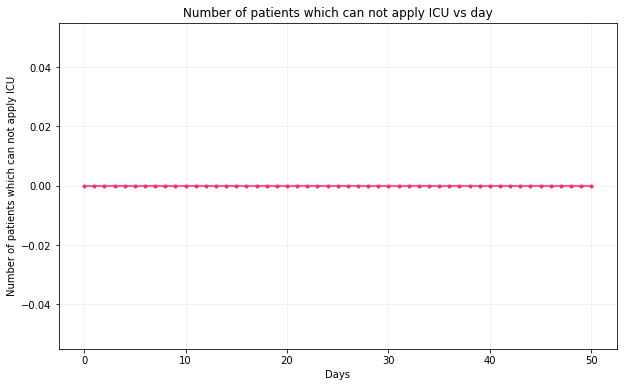

In [29]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(non_ICU_nums)-7), non_ICU_nums[7:], ".-" , color="#FF2973", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of patients which can not apply ICU")
plt.title("Number of patients which can not apply ICU vs day")
plt.grid(alpha=0.2)
plt.show()

### Average Case Analysis of the Istanbul

Because Istanbul is one of the worst cities of the Turkey. So we want to make this simlation analysis also for the Istanbul. During this analysis we assume that the cases in the Istanbul are 58.05 percent of the cases of Turkey. Because the average of this ratio is 0.5805 in the official declerations of the number of provincial cases. Our data sources can be found on our [`README.md`](https://github.com/HUmutOzdemir/COVIDDatathon/blob/master/README.md) file.

Calculate daily cases in order to give the simulation.

In [30]:
daily_cases = []
percentage_of_cases_in_Istanbul = 0.5805
for i in range(7, len(future_data)):
    daily_cases.append((future_data[i]-future_data[i-1])*percentage_of_cases_in_Istanbul)
daily_cases   

[2807.6418377432824,
 2848.5304861474424,
 2833.483620154601,
 2821.4935246182504,
 2814.129737935424,
 2834.429854398824,
 2831.3872302683685,
 2821.9877653475255,
 2797.9870206423334,
 2762.2570576032817,
 2715.192532945368,
 2661.2955445513403,
 2596.094500284768,
 2520.204871043787,
 2432.379860696837,
 2332.1389800124566,
 2218.9291822406412,
 2092.969827092291,
 1953.6365294563175,
 1800.6699624957846,
 1633.6755587504813,
 1452.3057102273394,
 1256.2093914421202,
 1045.164132413415,
 818.9079219764145,
 577.2347143117354,
 319.9601155344823,
 46.93368414298837]

Give daily cases to the simulation and simulation will produce some output. This is a basic Jackson Network Simulation. The Queueing Model of this simulation can be found on our report.

The first queue in the system represents the COVID positive patients in Istanbul. Also we assume that percentage of initial number of patients in the ICU in the Istanbul is same as the percentage of the cases in the Istanbul.

In this simulation we assume that the arrival process of the patients to the hospital is a Poisson process. Because in the estimation we make, we take into account the effects between 2 patients. So in the simulation, probability of a new COVID positive patient is independet from other patients. Because the time between 2 poisson processes is an exponential distribution random variable, we use exponential distribution.

Other interarrival time values and number of ICU units in the Istanbul are founded from data sources that can be found in the [`README.md`](https://github.com/HUmutOzdemir/COVIDDatathon/blob/master/README.md) file.

In [31]:
# Duration of the simulation(days)
duration = 57
# Input patient list
coming_patient_list = daily_cases
# Number of Intense Care used by COVID-19
num_used_COVID = int(1854 * percentage_of_cases_in_Istanbul)
# Length of day (in hours)
length_of_day = 24
# Coming patient rate of the first day
lambda_ = coming_patient_list[0]/length_of_day
# First interarrival time of the patient
interarrival_time=np.random.exponential(scale=1/lambda_)

In [32]:
event_queue = []
# Add first 2 events
heapq.heappush(event_queue,(interarrival_time,"Arrival")) 
heapq.heappush(event_queue,(24,"Day End"))
heapq.heappush(event_queue,(duration*24,"Finish"))

# Percantage of Patient Who Goes Intense Care
intensecare_percent = 0.061
# Percentage of death of person who goes intensecare unit
death_percentage = 0.51

# Guassian coefficiants of t_home Guassian Random Variable
t_home_coef = (84,36)
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_intensecare_coef = (756,252) 
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_health_coef = (216,12)

In [33]:
# Add Current Intense care Events to Event queue
for i in range(num_used_COVID):
    # Create Intense Care Time
    # We assume that every patient in the ICU was come here after the 12th day which is the mean value of goint the the ICU
    # Also because we cannot find any data, we assume that these days have equal probability
    t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
    # Add Intense Care Event to Event Queue
    heapq.heappush(event_queue,(t_intensecare,"Intense Care"))

# Intense Care Unit Stats
daily_intensecare_increase=0
max_num_of_intensecare = 7449
intensecare_fullness = 0.595
intensecare_used = max_num_of_intensecare * intensecare_fullness

day_counter = 0

# Output List
output_list = []

# Daily statistics
num_of_arrival = 0
num_of_death = 0
num_of_healthy = 0
num_of_noncared = 0

In [34]:
while event_queue:
    # Pop the event
    current_event = heapq.heappop(event_queue)
    if current_event[1] == "Day End":
        day_counter += 1
        if day_counter < len(coming_patient_list):
            # Add new intense care units
            max_num_of_intensecare += daily_intensecare_increase
            # Calculate next lambda
            lambda_=coming_patient_list[day_counter]/length_of_day
        # Add other day end event
        heapq.heappush(event_queue,(current_event[0]+24,"Day End"))
        # Generate Output
        output_list.append((num_of_arrival,num_of_healthy,num_of_death,(intensecare_used/max_num_of_intensecare)*100,num_of_noncared))
        # Make daily stats zero
        num_of_arrival = 0
        num_of_death = 0
        num_of_healthy = 0
        num_of_noncared = 0
        continue
    if current_event[1] == "Arrival":
        # Increase number of arrivals
        num_of_arrival += 1
        # Create Rest Time in Home-Hospital
        t_home = np.random.normal(loc=t_home_coef[0],scale=t_home_coef[1])
        # Add Home-Hospipal Event to Event Queue
        heapq.heappush(event_queue,(current_event[0]+t_home,"Home-Hospital"))
        if day_counter < len(coming_patient_list):
            # Create new interarrival time
            interarrival_time=np.random.exponential(scale=1/lambda_)
            # Add new Arrival Event to the Event Queue
            heapq.heappush(event_queue,(current_event[0]+interarrival_time,"Arrival"))
        continue
    if current_event[1] =="Home-Hospital":
        # Check the patient will go intense care unit or not
        if intensecare_percent > np.random.uniform(0,1):
            if intensecare_used < max_num_of_intensecare:
                # Use intense care unit
                intensecare_used += 1
                # Create Intense Care Time
                t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
                # Add Intense Care Event to Event Queue
                heapq.heappush(event_queue,(current_event[0]+t_intensecare,"Intense Care"))
            else:
                # Increase number of non cared patients
                num_of_noncared += 1
                # Add Death Out Event to the Event Queue 
                heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Intense Care":
        # Decrease used intense care unit
        intensecare_used -= 1
        # Check the patient will die or not
        if death_percentage > np.random.uniform(0,1):
            # Add Death Out Event to the Event Queue 
            heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Healthy-Out":
        # Increase number of healthy
        num_of_healthy += 1
        continue
    if current_event[1] == "Death-Out":
        #Increase number of death
        num_of_death += 1
        continue
    if current_event[1] == "Finish":
        break

In [35]:
output_list

[(2776, 0, 0, 59.593972345281244, 0),
 (2808, 0, 0, 59.88931400187945, 0),
 (2828, 0, 1, 60.412874211303524, 0),
 (2802, 0, 1, 61.50026849241509, 0),
 (2843, 0, 0, 63.35286615653107, 0),
 (2741, 0, 2, 65.17861457913814, 0),
 (2809, 0, 3, 67.4473754866425, 0),
 (2830, 1, 5, 69.93093032621827, 0),
 (2818, 23, 7, 72.1057188884414, 0),
 (2779, 89, 5, 74.45502752047254, 0),
 (2649, 264, 3, 76.5761175996778, 0),
 (2602, 722, 2, 78.63008457511074, 0),
 (2518, 1272, 5, 80.85857162035173, 0),
 (2441, 1896, 4, 82.92596321653913, 0),
 (2397, 2351, 6, 84.57719156933817, 0),
 (2288, 2573, 10, 86.3358168881729, 0),
 (2178, 2627, 18, 88.18841455228889, 0),
 (2084, 2682, 9, 89.70539669754329, 0),
 (1957, 2580, 10, 91.16868035977983, 0),
 (1883, 2624, 15, 92.37689622768156, 0),
 (1611, 2662, 13, 93.66565982011008, 0),
 (1470, 2587, 29, 94.3234662370788, 0),
 (1242, 2579, 22, 95.16921734461002, 0),
 (1035, 2424, 28, 95.89414686535105, 0),
 (795, 2435, 31, 96.43113169552959, 0),
 (575, 2298, 33, 96.78017

In [36]:
healthy_patient_nums = [7089 * percentage_of_cases_in_Istanbul]
death_patient_nums = [1643 * percentage_of_cases_in_Istanbul]
intense_care_percets = []
non_ICU_nums = [0]
for output in output_list:
    healthy_patient_nums.append(output[1] + healthy_patient_nums[len(healthy_patient_nums)-1])
    death_patient_nums.append(output[2] + death_patient_nums[len(death_patient_nums)-1])
    intense_care_percets.append(output[3])
    non_ICU_nums.append(output[4] + non_ICU_nums[len(non_ICU_nums)-1])

### Average Case Plots of Istanbul

Plot total cases vs day graph to see results of model clearly.

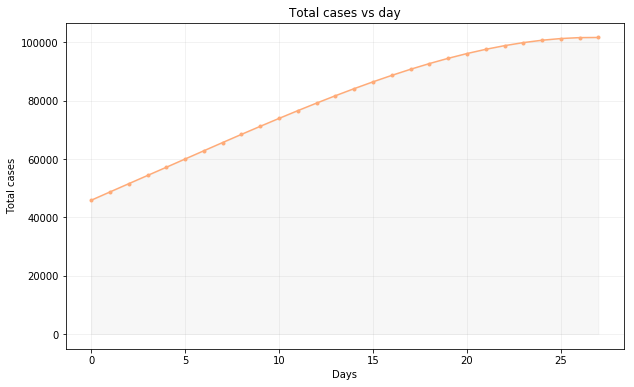

In [37]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(future_data)-7), np.array(future_data[7:]) * percentage_of_cases_in_Istanbul, color="black", alpha=0.02)
plt.fill_between(range(len(future_data)-7), np.array(future_data[7:]) * percentage_of_cases_in_Istanbul, color="black", alpha=0.01)
plt.plot(range(len(future_data)-7), np.array(future_data[7:]) * percentage_of_cases_in_Istanbul,".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("Total cases")
plt.title("Total cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot new cases vs day graph to see results of model clearly.

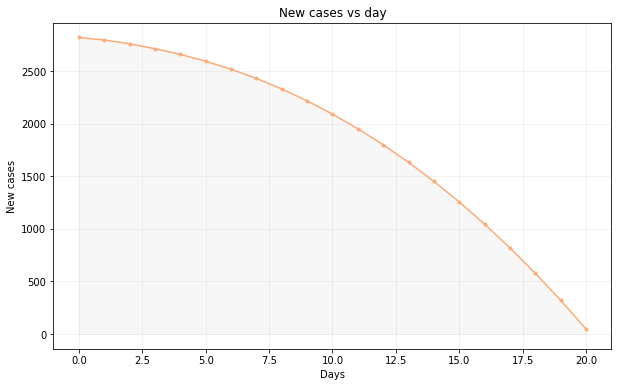

In [38]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.02)
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.01)
plt.plot(range(len(daily_cases)-7), daily_cases[7:],".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("New cases")
plt.title("New cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of healthy covid-19 patients vs day graph to see results of simulation clearly.

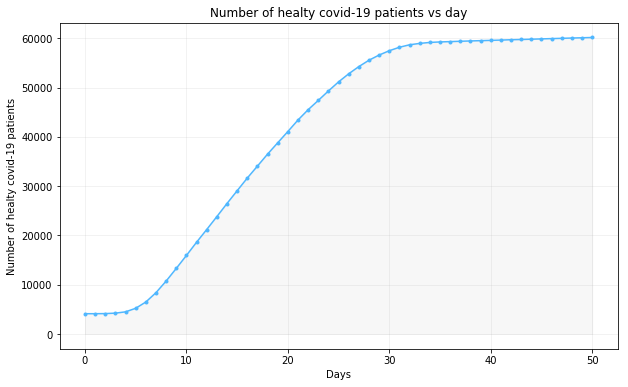

In [39]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between( range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:],".-" , color="#4FB7FF", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of healty covid-19 patients")
plt.title("Number of healty covid-19 patients vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of deaths vs day graph to see results of simulation clearly.

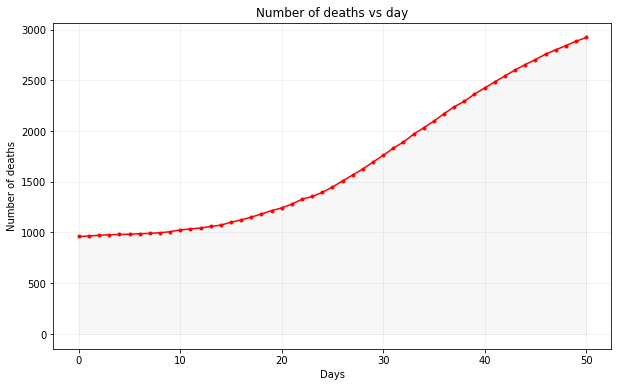

In [40]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(death_patient_nums)-7), death_patient_nums[7:], ".-" , color="red", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.title("Number of deaths vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of intense care percentage vs day graph to see results of simulation clearly.

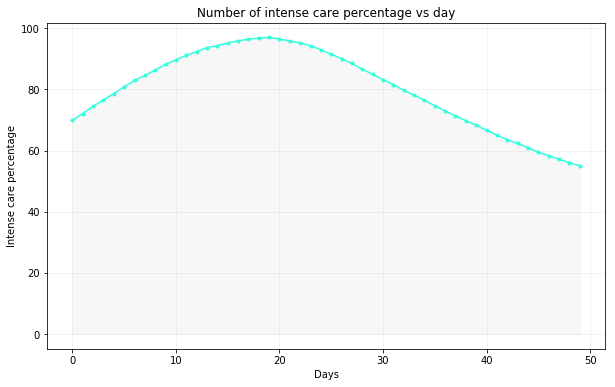

In [41]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.02)
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.01)
plt.plot(range(len(intense_care_percets)-7), intense_care_percets[7:], ".-" , color="#31FFDE", alpha=1)
plt.xlabel("Days")
plt.ylabel("Intense care percentage")
plt.title("Number of intense care percentage vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of patients which can not apply ICU vs day graph to see results of simulation clearly.

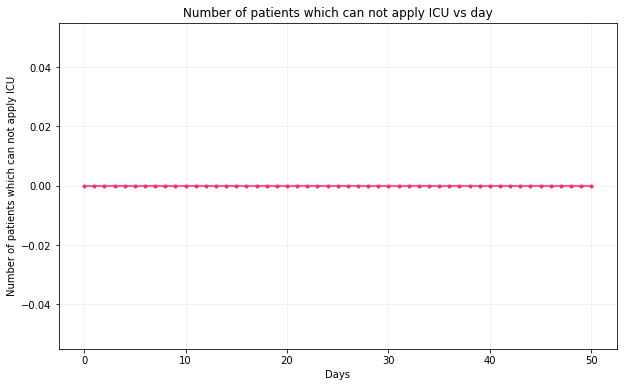

In [42]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(non_ICU_nums)-7), non_ICU_nums[7:], ".-" , color="#FF2973", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of patients which can not apply ICU")
plt.title("Number of patients which can not apply ICU vs day")
plt.grid(alpha=0.2)
plt.show()

### Clustering

We cluster countries and find countries which can not control epidemic very well to predict what may happen in Turkey if we behave like such countries. We cluster countries according to their potential output record values divided by potential input record values which means increase rate of cases in that country. If average of this increase rate of a country is high, it means it is a country which can not control epidemic very well. Otherwise, it is a country which control epidemic well.

In [43]:
nofday = 30 # We look at countries which have cases more than 100 for more than 30 days because Turkey is a such country.
threshold = nofday*(noffday+1)/2 if nofday <=6 else 21 + (nofday-6)*7 # We calculate the threshold value. If a country has less data than threshold after operations, this means it is country which has cases for less than 30 days. 
mydict = {}
for column in df.columns:
    if column == "Turkey": # Skip Turkey
        continue
    list_ = []
    for i in range(len(df[column])):
        if df[column][i] >= 100: # We assume that a country really has epidemic inside if that country has cases more than 100.
            if i-1 < 0 or df[column][i-1] == 0:
                list_.append(1)
            else:
                for j in range(1, min(i, 8)):
                    if df[column][i-j] >= 10: # Numbers less than 10 may give exaggerated and false rates, so we ignore them.
                        list_.append(df[column][i] / df[column][i-j])
    if(len(list_)>=threshold):
        mydict[column] = [np.array(list_).mean()]



Convert this country-average increase rate dictionary to a dataframe.

In [44]:
df_first35_mean = pd.DataFrame(data=mydict).T
df_first35_mean.head()

,0
Algeria,1.763746
Argentina,1.790418
Armenia,1.767071
Australia,1.778877
Austria,2.130104


There are 75 countries which is suitable for our definition.

In [45]:
len(df_first35_mean)

75

Try different number of clusters for KMeans algorithm and choose the best number of cluster

In [46]:
distortions = []
inertias = []
silhouettes = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_first35_mean)
    kmeans.labels_
    silhouettes.append(silhouette_score(df_first35_mean, kmeans.labels_))
    inertias.append(kmeans.inertia_)
    distortions.append(sum(np.min(cdist(df_first35_mean, kmeans.cluster_centers_, 'euclidean'),axis=1)) / df_first35_mean.shape[0])

Silhouette score should be high for good number of clusters, so number of clusters could be a value greater than 4.

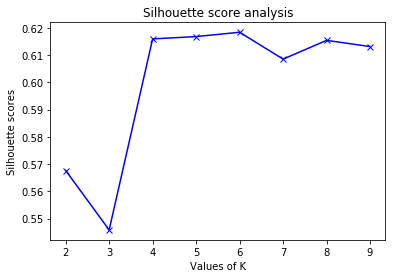

In [47]:
plt.plot(range(2, 10), silhouettes, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette scores') 
plt.title('Silhouette score analysis') 
plt.show()

We search for an elbow in this graph and location of elbow is the best number of clusters. It is 4.

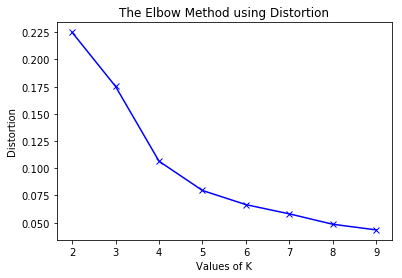

In [48]:
plt.plot(range(2, 10), distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

We search for an elbow in this graph and location of elbow is the best number of clusters. It is 4.

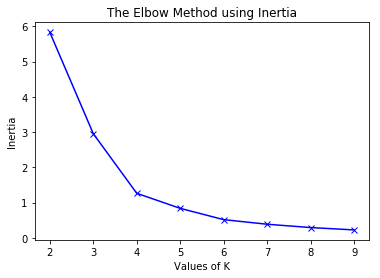

In [49]:
plt.plot(range(2, 10), inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

4 is the best number of clusters for this data when we look at these 3 graphs above. So we choose 4 as number of clusters and train KMeans model.

In [50]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_first35_mean)
kmeans.labels_

array([3, 3, 3, 3, 2, 1, 2, 3, 2, 1, 2, 2, 3, 3, 1, 3, 3, 0, 0, 0, 1, 2,
       3, 2, 2, 1, 3, 1, 3, 3, 1, 2, 1, 2, 3, 2, 1, 1, 1, 1, 3, 2, 3, 3,
       3, 3, 2, 3, 0, 3, 2, 3, 2, 2, 0, 3, 2, 1, 3, 3, 1, 1, 3, 3, 2, 2,
       2, 2, 1, 3, 3, 2, 2, 1, 1])

When we look at the cluster centers, label 0 countries have the highest increase rate. So, in order to calculate a bad scenario for Turkey's situation, we should only choose them.

In [51]:
kmeans.cluster_centers_

array([[3.1013515 ],
       [1.42660099],
       [2.35416555],
       [1.88029124]])

Graph that shows the clusters of our clustring model. Dots are cluster centers and crosses are the countries.

Text(0.5, 1.0, 'Country Clusters')

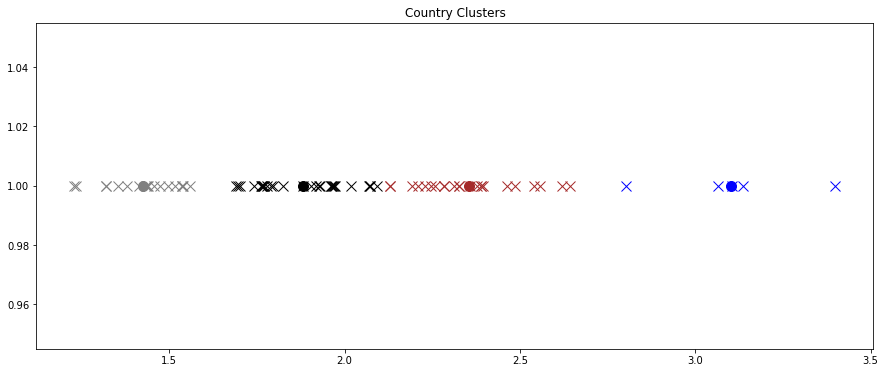

In [52]:
plt.figure(figsize=(15, 6))
colors = ["blue" ,"grey" ,"brown" ,"black"]
for n, y in enumerate(kmeans.cluster_centers_):
    plt.plot(y,1, marker='o', color=colors[n], ms=10)
for n,y in enumerate(kmeans.labels_):
    plt.plot(df_first35_mean[0][n],1,marker='x', color=colors[kmeans.labels_[n]],ms=10)
plt.title('Country Clusters')

Choose countries which can not control epidemic very well.

In [53]:
max_index = np.where(kmeans.cluster_centers_ == np.amax(kmeans.cluster_centers_))[0]
chosen_columns = list(df_first35_mean.index[[True if a == max_index else False for a in kmeans.labels_]])
chosen_columns

['Denmark', 'Dominican Republic', 'Ecuador', 'Pakistan', 'Qatar']

### Prepare Input and Output Data

Create input and output data from the dataframe. Each input record has 8 attributes. First of them is mean of other seven attributes and other seven attributes are the data at previous 7 days respectively. Output is the next day which want to be predicted. Choose only the data of chosen countries.

In [54]:
how_many_previos = 7
X = []
y = []

for column in df.columns:
    if  not (column in chosen_columns):
        continue

    for i in range(len(df) - how_many_previos):
        if ((0 != df[column][i])) and (df[column][i: i+how_many_previos].sum()+df[column][i+how_many_previos] != 0):
            X.append(np.concatenate([np.array([np.array(df[column][i: i+how_many_previos]).mean()]), np.array(df[column][i: i+how_many_previos])]))
            y.append(df[column][i+how_many_previos])

X = np.array(X)
y = np.array(y)

Normalize the input and output data so that machine learning models can perform better.

In [55]:
X_max = X.max()
X = X / X_max

y = y / X_max

There are totally 215 record in our input data.

In [56]:
len(X)

215

### Model Training

Split train and test data and create an example case to see how models work.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
example = np.array([100, 150, 200, 250, 300 ,350, 400])

Train 6 different machine learning algorithms to see which one performs best. One can see the r2 score, mse and mae statistics for train and test set for each algorithm and result of prediction. Intercept and coefficients of linear models can also be found below. Lastly, we do a cross validation to see which one performs best and we compare models according to 3 metrics(mean squared error, mean absolute error and r2 score). Linear regression model performs best, so we continue with it. We do not train a neural network model because we saw that it does not work very well and it need so much hyperparameter tuning.  

In [58]:
lin_model = LinearRegression().fit(X_train, y_train)
print("Linear regression model")
print("r2 score: ", lin_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, lin_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, lin_model.predict(X_test)))
print("intercept: ", lin_model.intercept_,", coefficients: " , lin_model.coef_)
print("prediction: ", lin_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(lin_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Linear regression model
r2 score:  0.9833556424761165
mse:  0.0014432812968470403
mae:  0.015466280794356784
intercept:  0.0024228964244571993 , coefficients:  [ 0.12771148  0.24399298 -0.43458159  0.13360475  0.03232423 -0.07754637
 -0.84220486  1.83839123]
prediction:  463.1911345990091
cross validation r2 score:  0.9944077427919776
cross validation mse:  0.0005014546311185254
cross validation mae:  0.010954628272429998


In [59]:
lasso_model = Lasso().fit(X_train, y_train)
print("Lasso regression model")
print("r2 score: ", lasso_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, lasso_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, lasso_model.predict(X_test)))
print("intercept: ", lasso_model.intercept_,", coefficients: " , lasso_model.coef_)
print("prediction: ", lasso_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(lasso_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Lasso regression model
r2 score:  -0.14842242923482019
mse:  0.099583093586873
mae:  0.2280870297096434
intercept:  0.21839754011451193 , coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]
prediction:  1796.3197674418607
cross validation r2 score:  -0.11339766631872608
cross validation mse:  0.07184955617072451
cross validation mae:  0.21515599823119702


In [60]:
ridge_model = Ridge().fit(X_train, y_train)
print("Ridge regression model")
print("r2 score: ", ridge_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, ridge_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, ridge_model.predict(X_test)))
print("intercept: ", ridge_model.intercept_,", coefficients: " , ridge_model.coef_)
print("prediction: ", ridge_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(ridge_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Ridge regression model
r2 score:  0.9848404185667217
mse:  0.0013145319859468694
mae:  0.022063657745840116
intercept:  0.021261235027949327 , coefficients:  [0.14642743 0.07817345 0.08985118 0.09439341 0.1182291  0.15182178
 0.21777051 0.27475255]
prediction:  512.8787266532846
cross validation r2 score:  0.9840359669289105
cross validation mse:  0.0012166638125795837
cross validation mae:  0.022681270119849252


In [61]:
elastic_model = ElasticNet().fit(X_train, y_train)
print("Elastic net regression model")
print("r2 score: ", elastic_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, elastic_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, elastic_model.predict(X_test)))
print("intercept: ", elastic_model.intercept_,", coefficients: " , elastic_model.coef_)
print("prediction: ", elastic_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(elastic_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Elastic net regression model
r2 score:  -0.14842242923482019
mse:  0.099583093586873
mae:  0.2280870297096434
intercept:  0.21839754011451193 , coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]
prediction:  1796.3197674418607
cross validation r2 score:  -0.11339766631872608
cross validation mse:  0.07184955617072451
cross validation mae:  0.21515599823119702


In [62]:
forest_model = RandomForestRegressor().fit(X_train, y_train)
print("Random forest regression model")
print("r2 score: ", forest_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, forest_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, forest_model.predict(X_test)))
print("prediction: ", forest_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(forest_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

Random forest regression model
r2 score:  0.9940089808689485
mse:  0.0005194989261971843
mae:  0.015758360146721634
prediction:  476.6
cross validation r2 score:  0.9837775580015815
cross validation mse:  0.0014053801597272353
cross validation mae:  0.020743719822626842


C:\Users\umutd\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [63]:
neighbor_model = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
print("K nearest neighbors regression model")
print("r2 score: ", neighbor_model.score(X_test, y_test))
print("mse: ", mean_squared_error(y_test, neighbor_model.predict(X_test)))
print("mae: ", mean_absolute_error(y_test, neighbor_model.predict(X_test)))
print("prediction: ", neighbor_model.predict([np.concatenate([np.array([example.mean()]), example])]/X_max)[0]*X_max)
cross_validation = cross_validate(neighbor_model, X, y, cv=5, scoring = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error"))
print("cross validation r2 score: ", cross_validation["test_r2"].mean())
print("cross validation mse: ", -cross_validation["test_neg_mean_squared_error"].mean())
print("cross validation mae: ", -cross_validation["test_neg_mean_absolute_error"].mean())

K nearest neighbors regression model
r2 score:  0.9546882055036745
mse:  0.003929119248326787
mae:  0.03360189439457129
prediction:  567.25
cross validation r2 score:  0.9719790638307927
cross validation mse:  0.0025350650828051017
cross validation mae:  0.025301958012299425


Train a linear regression model with full input and output data to calculate the number of cases in next days in Turkey if we do not take precautions and behave like one of the countries which can not control epidemic very well.

In [64]:
lin_model = LinearRegression().fit(X, y)

### Prediction for Worst Case Scenario

Our model produces output regarding to the previous 7 days and their mean value. When we train our model with the data for worst countries, our machine learning model learns the types of trends in worst countries from 7 days and predicts the next day. When we give 7 total cases of Turkey, model finds the trend in Turkey and predict next total case in Turkey by using this trend information and this trend tend to be a trend of Turkey when it does not take precautions because we train this model by using data of countries which does or can not take precautions.

Make predictions given last 7 days total cases.

In [65]:
future_data = [47029, 52167, 56956, 61049, 65111, 69392, 74193]

def future(future_dat):
    future_dat.append(lin_model.predict([([np.mean(future_dat[-7:])]+ future_dat[-7:])/X_max])[0]*X_max)
    return future_dat

for i in range(57):
    future_data = future(future_data)

for i in range(len(future_data) - 1):
    if future_data[i+1] < future_data[i]:
        future_data = future_data[:i+1]
        break

future_data

[47029,
 52167,
 56956,
 61049,
 65111,
 69392,
 74193,
 77951.6366002975,
 81645.13685519504,
 85331.97652256118,
 89218.31921837499,
 93438.70493442968,
 97856.87501485723,
 102508.96952515443,
 107360.6438668857,
 112425.51133593438,
 117727.81843637835,
 123273.72982692096,
 129081.8439670758,
 135161.0906215605,
 141523.75192222712,
 148183.2746222915,
 155152.67968505458,
 162447.05743084903,
 170081.38352049462,
 178071.5841953268,
 186434.29068954362,
 195186.78742033849,
 204347.2842350319,
 213934.77368454772,
 223969.16617585707,
 234471.2984117963,
 245462.96848598507,
 256966.99976691313,
 269007.27274338226,
 281608.78389180166,
 294797.69462478673,
 308601.38518391666,
 323048.5129585848,
 338169.07056454476,
 353994.4489261832,
 370557.5021551369,
 387892.61575008684,
 406035.7781089012,
 425024.6551210724,
 444898.6684367308,
 465699.0772782297,
 487469.06409661245,
 510253.82423017506,
 534100.6597214302,
 559059.0775246896,
 585180.8922816671,
 612520.3338909113,
 64

Calculate daily cases in order to give the simulation.

In [66]:
daily_cases = []
for i in range(7, len(future_data)):
    daily_cases.append(future_data[i]-future_data[i-1])
daily_cases        

[3758.6366002974974,
 3693.5002548975463,
 3686.8396673661337,
 3886.342695813815,
 4220.38571605469,
 4418.170080427546,
 4652.094510297204,
 4851.674341731268,
 5064.8674690486805,
 5302.30710044397,
 5545.911390542606,
 5808.1141401548375,
 6079.2466544846975,
 6362.66130066663,
 6659.522700064379,
 6969.405062763079,
 7294.3777457944525,
 7634.32608964559,
 7990.200674832187,
 8362.706494216807,
 8752.496730794868,
 9160.496814693412,
 9587.489449515822,
 10034.39249130935,
 10502.132235939236,
 10991.670074188762,
 11504.031280928059,
 12040.272976469132,
 12601.511148419406,
 13188.910732985067,
 13803.69055912993,
 14447.127774668159,
 15120.55760595994,
 15825.37836163846,
 16563.05322895368,
 17335.113594949944,
 18143.162358814385,
 18988.8770121712,
 19874.013315658376,
 20800.408841498895,
 21769.98681838275,
 22784.76013356261,
 23846.8354912551,
 24958.41780325945,
 26121.81475697749,
 27339.44160924421,
 28613.826201050077,
 29947.614203752717,
 31343.574613087927,
 3280

### Worst Case Simulation

Give daily cases to the simulation and simulation will produce some output. This is a basic Jackson Network Simulation. The Queueing Model of this simulation can be found on our report.

The first queue in the system represents the COVID positive patients in Turkey. In this simulation we assume that the arrival process of the patients to the hospital is a Poisson process. Because in the estimation we make, we take into account the effects between 2 patients. So in the simulation, probability of a new COVID positive patient is independet from other patients. Because the time between 2 poisson processes is an exponential distribution random variable, we use exponential distribution.

Other interarrival time values are founded from data sources that can be found in the [`README.md`](https://github.com/HUmutOzdemir/COVIDDatathon/blob/master/README.md) file.

In [67]:
# Duration of the simulation(days)
duration = 57
# Input patient list
coming_patient_list = daily_cases
# Number of Intense Care used by COVID-19
num_used_COVID = 1854
# Length of day (in hours)
length_of_day = 24
# Coming patient rate of the first day
lambda_ = coming_patient_list[0]/length_of_day
# First interarrival time of the patient
interarrival_time=np.random.exponential(scale=1/lambda_)

In [68]:
event_queue = []
# Add first 2 events
heapq.heappush(event_queue,(interarrival_time,"Arrival")) 
heapq.heappush(event_queue,(24,"Day End"))
heapq.heappush(event_queue,(duration*24,"Finish"))

# Percantage of Patient Who Goes Intense Care
intensecare_percent = 0.061
# Percentage of death of person who goes intensecare unit
death_percentage = 0.51

# Guassian coefficiants of t_home Guassian Random Variable
t_home_coef = (84,36)
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_intensecare_coef = (756,252) 
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_health_coef = (216,12)

In [69]:
# Add Current Intense care Events to Event queue
for i in range(num_used_COVID):
    # Create Intense Care Time
    # We assume that every patient in the ICU was come here after the 12th day which is the mean value of goint the the ICU
    # Also because we cannot find any data, we assume that these days have equal probability
    t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
    # Add Intense Care Event to Event Queue
    heapq.heappush(event_queue,(t_intensecare,"Intense Care"))

# Intense Care Unit Stats
daily_intensecare_increase=0
max_num_of_intensecare = 25446
intensecare_fullness = 0.595
intensecare_used = max_num_of_intensecare * intensecare_fullness

day_counter = 0

# Output List
output_list = []

# Daily statistics
num_of_arrival = 0
num_of_death = 0
num_of_healthy = 0
num_of_noncared = 0

In [70]:
while event_queue:
    # Pop the event
    current_event = heapq.heappop(event_queue)
    if current_event[1] == "Day End":
        day_counter += 1
        if day_counter < len(coming_patient_list):
            # Add new intense care units
            max_num_of_intensecare += daily_intensecare_increase
            # Calculate next lambda
            lambda_=coming_patient_list[day_counter]/length_of_day
        # Add other day end event
        heapq.heappush(event_queue,(current_event[0]+24,"Day End"))
        # Generate Output
        output_list.append((num_of_arrival,num_of_healthy,num_of_death,(intensecare_used/max_num_of_intensecare)*100,num_of_noncared))
        # Make daily stats zero
        num_of_arrival = 0
        num_of_death = 0
        num_of_healthy = 0
        num_of_noncared = 0
        continue
    if current_event[1] == "Arrival":
        # Increase number of arrivals
        num_of_arrival += 1
        # Create Rest Time in Home-Hospital
        t_home = np.random.normal(loc=t_home_coef[0],scale=t_home_coef[1])
        # Add Home-Hospipal Event to Event Queue
        heapq.heappush(event_queue,(current_event[0]+t_home,"Home-Hospital"))
        if day_counter < len(coming_patient_list):
            # Create new interarrival time
            interarrival_time=np.random.exponential(scale=1/lambda_)
            # Add new Arrival Event to the Event Queue
            heapq.heappush(event_queue,(current_event[0]+interarrival_time,"Arrival"))
        continue
    if current_event[1] =="Home-Hospital":
        # Check the patient will go intense care unit or not
        if intensecare_percent > np.random.uniform(0,1):
            if intensecare_used < max_num_of_intensecare:
                # Use intense care unit
                intensecare_used += 1
                # Create Intense Care Time
                t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
                # Add Intense Care Event to Event Queue
                heapq.heappush(event_queue,(current_event[0]+t_intensecare,"Intense Care"))
            else:
                # Increase number of non cared patients
                num_of_noncared += 1
                # Add Death Out Event to the Event Queue 
                heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Intense Care":
        # Decrease used intense care unit
        intensecare_used -= 1
        # Check the patient will die or not
        if death_percentage > np.random.uniform(0,1):
            # Add Death Out Event to the Event Queue 
            heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Healthy-Out":
        # Increase number of healthy
        num_of_healthy += 1
        continue
    if current_event[1] == "Death-Out":
        #Increase number of death
        num_of_death += 1
        continue
    if current_event[1] == "Finish":
        break

In [71]:
output_list

[(3896, 0, 1, 59.51964945374518, 0),
 (3688, 0, 1, 59.574667924231704, 0),
 (3658, 0, 1, 59.81046136917393, 0),
 (3929, 0, 1, 60.28990804055647, 0),
 (4178, 1, 1, 60.9697791401399, 0),
 (4364, 1, 2, 61.771476852943486, 0),
 (4746, 0, 4, 62.62819303623359, 0),
 (4706, 3, 2, 63.55171736225732, 0),
 (5049, 24, 9, 64.55776939401085, 0),
 (5353, 124, 10, 65.5677513165134, 0),
 (5418, 391, 4, 66.67991039849092, 0),
 (6030, 931, 7, 67.83922816945689, 0),
 (6158, 1800, 8, 68.92387801619114, 0),
 (6299, 2561, 14, 70.16965338363593, 0),
 (6623, 3268, 15, 71.4979564568105, 0),
 (6998, 3623, 15, 72.74766171500431, 0),
 (7240, 3762, 16, 74.17028216615577, 0),
 (7670, 4052, 23, 75.58504283580916, 0),
 (7993, 4254, 26, 77.17664858916922, 0),
 (8285, 4381, 27, 78.6228483848149, 0),
 (8810, 4660, 29, 80.28912206240666, 0),
 (9273, 4881, 45, 81.84142890827634, 0),
 (9476, 5043, 32, 83.5705808378527, 0),
 (10174, 5422, 50, 85.28008331368387, 0),
 (10536, 5722, 56, 87.18215043621787, 0),
 (11023, 5905, 52

In [72]:
healthy_patient_nums = [7089]
death_patient_nums = [1643]
intense_care_percets = []
non_ICU_nums = [0]
for output in output_list:
    healthy_patient_nums.append(output[1] + healthy_patient_nums[len(healthy_patient_nums)-1])
    death_patient_nums.append(output[2] + death_patient_nums[len(death_patient_nums)-1])
    intense_care_percets.append(output[3])
    non_ICU_nums.append(output[4] + non_ICU_nums[len(non_ICU_nums)-1])

### Worst Case Plots

Plot total cases vs day graph to see results of model clearly.

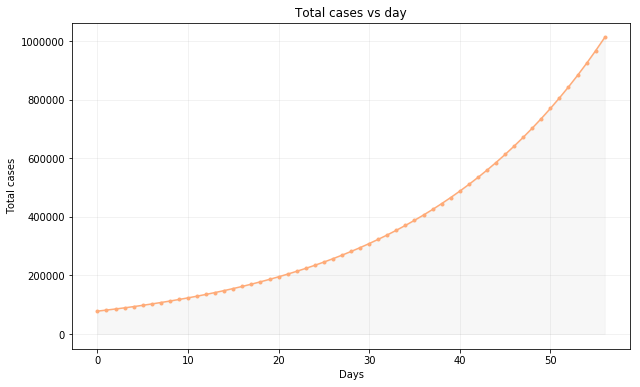

In [73]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(future_data)-7), future_data[7:], color="black", alpha=0.02)
plt.fill_between(range(len(future_data)-7), future_data[7:], color="black", alpha=0.01)
plt.plot(range(len(future_data)-7), future_data[7:],".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("Total cases")
plt.title("Total cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot new cases vs day graph to see results of model clearly.

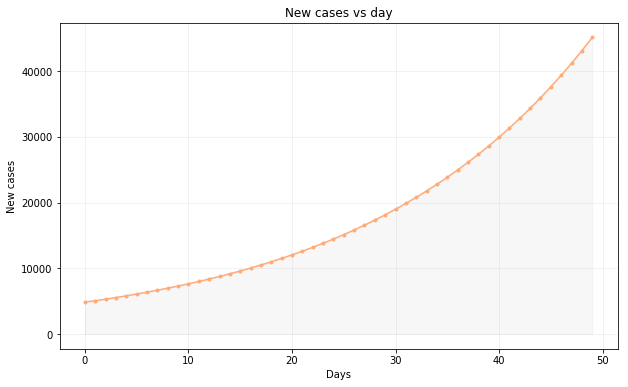

In [74]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.02)
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.01)
plt.plot(range(len(daily_cases)-7), daily_cases[7:],".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("New cases")
plt.title("New cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of healthy covid-19 patients vs day graph to see results of simulation clearly.

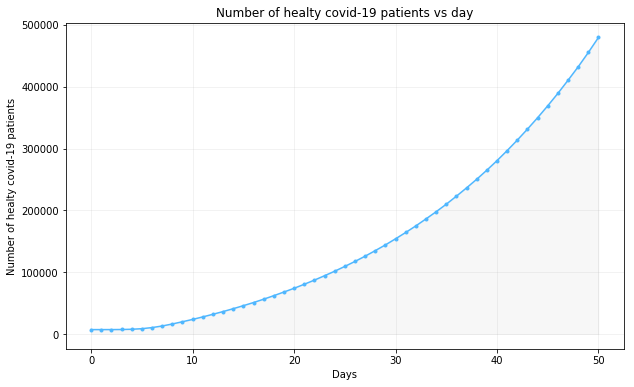

In [75]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between( range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:],".-" , color="#4FB7FF", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of healty covid-19 patients")
plt.title("Number of healty covid-19 patients vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of deaths vs day graph to see results of simulation clearly.

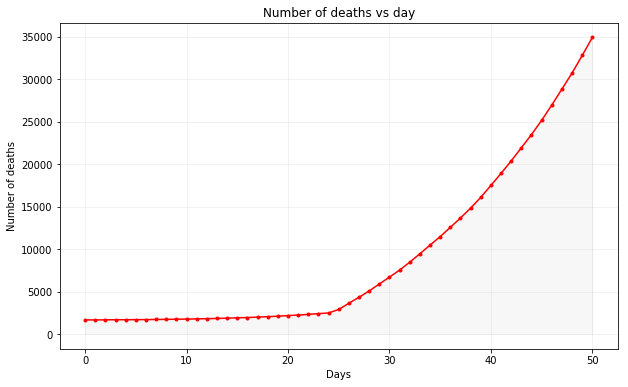

In [76]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(death_patient_nums)-7), death_patient_nums[7:], ".-" , color="red", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.title("Number of deaths vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of intense care percentage vs day graph to see results of simulation clearly.

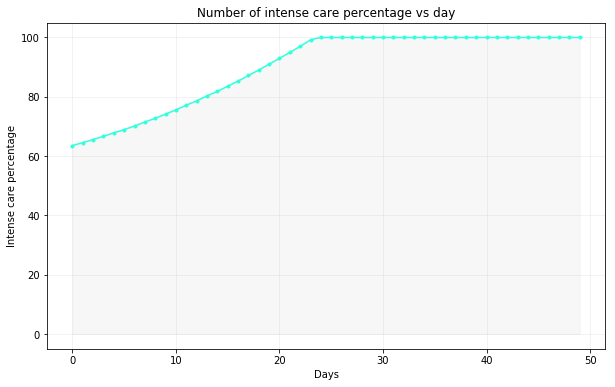

In [77]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.02)
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.01)
plt.plot(range(len(intense_care_percets)-7), intense_care_percets[7:], ".-" , color="#31FFDE", alpha=1)
plt.xlabel("Days")
plt.ylabel("Intense care percentage")
plt.title("Number of intense care percentage vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of patients which can not apply ICU vs day graph to see results of simulation clearly.

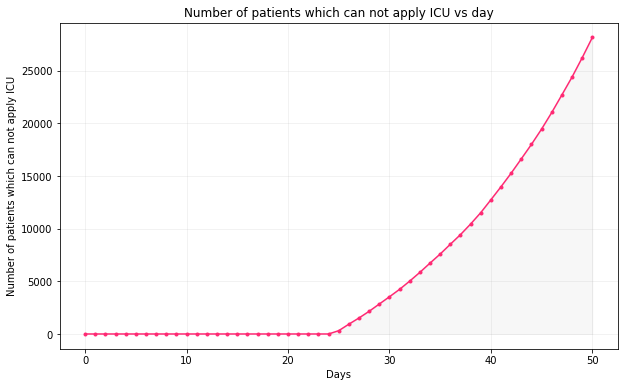

In [78]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(non_ICU_nums)-7), non_ICU_nums[7:], ".-" , color="#FF2973", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of patients which can not apply ICU")
plt.title("Number of patients which can not apply ICU vs day")
plt.grid(alpha=0.2)
plt.show()

### Worst Case Analysis of the Istanbul

Because Istanbul is one of the worst cities of the Turkey. So we want to make this simlation analysis also for the Istanbul. During this analysis we assume that the cases in the Istanbul are 58.05 percent of the cases of Turkey. Because the average of this ratio is 0.5805 in the official declerations of the number of provincial cases. Our data sources can be found on our [`README.md`](https://github.com/HUmutOzdemir/COVIDDatathon/blob/master/README.md) file.

Calculate daily cases in order to give the simulation.

In [79]:
daily_cases = []
percentage_of_cases_in_Istanbul = 0.5805
for i in range(7, len(future_data)):
    daily_cases.append((future_data[i]-future_data[i-1])*percentage_of_cases_in_Istanbul)
daily_cases   

[2181.8885464726973,
 2144.0768979680256,
 2140.2104269060405,
 2256.0219349199197,
 2449.933908169748,
 2564.7477316881905,
 2700.5408632275266,
 2816.396955375001,
 2940.155565782759,
 3077.9892718077244,
 3219.401562209983,
 3371.610258359883,
 3529.002682928367,
 3693.524885036979,
 3865.8529273873723,
 4045.7396389339674,
 4234.38628143368,
 4431.726295039265,
 4638.311491740085,
 4854.551119892857,
 5080.824352226421,
 5317.668400929526,
 5565.537625443935,
 5824.964841205078,
 6096.487762962727,
 6380.6644780665765,
 6678.090158578738,
 6989.378462840331,
 7315.177221657465,
 7656.162680497831,
 8013.042369574924,
 8386.557673194866,
 8777.483690259745,
 9186.632138931127,
 9614.852399407611,
 10063.033441868443,
 10532.10574929175,
 11023.043105565383,
 11536.864729739687,
 12074.637332490109,
 12637.477348071186,
 13226.553257533094,
 13843.088002673587,
 14488.361534792111,
 15163.713466425432,
 15870.545854166265,
 16610.32610970957,
 17384.59004527845,
 18194.945062897543,


Give daily cases to the simulation and simulation will produce some output. This is a basic Jackson Network Simulation. The Queueing Model of this simulation can be found on our report.

The first queue in the system represents the COVID positive patients in Istanbul. Also we assume that percentage of initial number of patients in the ICU in the Istanbul is same as the percentage of the cases in the Istanbul.

In this simulation we assume that the arrival process of the patients to the hospital is a Poisson process. Because in the estimation we make, we take into account the effects between 2 patients. So in the simulation, probability of a new COVID positive patient is independet from other patients. Because the time between 2 poisson processes is an exponential distribution random variable, we use exponential distribution.

Other interarrival time values and number of ICU units in the Istanbul are founded from data sources that can be found in the [`README.md`](https://github.com/HUmutOzdemir/COVIDDatathon/blob/master/README.md) file.

In [80]:
# Duration of the simulation(days)
duration = 57
# Input patient list
coming_patient_list = daily_cases
# Number of Intense Care used by COVID-19
num_used_COVID = int(1854 * percentage_of_cases_in_Istanbul)
# Length of day (in hours)
length_of_day = 24
# Coming patient rate of the first day
lambda_ = coming_patient_list[0]/length_of_day
# First interarrival time of the patient
interarrival_time=np.random.exponential(scale=1/lambda_)

In [81]:
event_queue = []
# Add first 2 events
heapq.heappush(event_queue,(interarrival_time,"Arrival")) 
heapq.heappush(event_queue,(24,"Day End"))
heapq.heappush(event_queue,(duration*24,"Finish"))

# Percantage of Patient Who Goes Intense Care
intensecare_percent = 0.061
# Percentage of death of person who goes intensecare unit
death_percentage = 0.51

# Guassian coefficiants of t_home Guassian Random Variable
t_home_coef = (84,36)
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_intensecare_coef = (756,252) 
# Guassiam coefficiants of t_intencecare Guassian Random Variable
t_health_coef = (216,12)

In [82]:
# Add Current Intense care Events to Event queue
for i in range(num_used_COVID):
    # Create Intense Care Time
    # We assume that every patient in the ICU was come here after the 12th day which is the mean value of goint the the ICU
    # Also because we cannot find any data, we assume that these days have equal probability
    t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
    # Add Intense Care Event to Event Queue
    heapq.heappush(event_queue,(t_intensecare,"Intense Care"))

# Intense Care Unit Stats
daily_intensecare_increase=0
max_num_of_intensecare = 7449
intensecare_fullness = 0.595
intensecare_used = max_num_of_intensecare * intensecare_fullness

day_counter = 0

# Output List
output_list = []

# Daily statistics
num_of_arrival = 0
num_of_death = 0
num_of_healthy = 0
num_of_noncared = 0

In [83]:
while event_queue:
    # Pop the event
    current_event = heapq.heappop(event_queue)
    if current_event[1] == "Day End":
        day_counter += 1
        if day_counter < len(coming_patient_list):
            # Add new intense care units
            max_num_of_intensecare += daily_intensecare_increase
            # Calculate next lambda
            lambda_=coming_patient_list[day_counter]/length_of_day
        # Add other day end event
        heapq.heappush(event_queue,(current_event[0]+24,"Day End"))
        # Generate Output
        output_list.append((num_of_arrival,num_of_healthy,num_of_death,(intensecare_used/max_num_of_intensecare)*100,num_of_noncared))
        # Make daily stats zero
        num_of_arrival = 0
        num_of_death = 0
        num_of_healthy = 0
        num_of_noncared = 0
        continue
    if current_event[1] == "Arrival":
        # Increase number of arrivals
        num_of_arrival += 1
        # Create Rest Time in Home-Hospital
        t_home = np.random.normal(loc=t_home_coef[0],scale=t_home_coef[1])
        # Add Home-Hospipal Event to Event Queue
        heapq.heappush(event_queue,(current_event[0]+t_home,"Home-Hospital"))
        if day_counter < len(coming_patient_list):
            # Create new interarrival time
            interarrival_time=np.random.exponential(scale=1/lambda_)
            # Add new Arrival Event to the Event Queue
            heapq.heappush(event_queue,(current_event[0]+interarrival_time,"Arrival"))
        continue
    if current_event[1] =="Home-Hospital":
        # Check the patient will go intense care unit or not
        if intensecare_percent > np.random.uniform(0,1):
            if intensecare_used < max_num_of_intensecare:
                # Use intense care unit
                intensecare_used += 1
                # Create Intense Care Time
                t_intensecare = np.random.normal(loc=t_intensecare_coef[0], scale= t_intensecare_coef[1])
                # Add Intense Care Event to Event Queue
                heapq.heappush(event_queue,(current_event[0]+t_intensecare,"Intense Care"))
            else:
                # Increase number of non cared patients
                num_of_noncared += 1
                # Add Death Out Event to the Event Queue 
                heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Intense Care":
        # Decrease used intense care unit
        intensecare_used -= 1
        # Check the patient will die or not
        if death_percentage > np.random.uniform(0,1):
            # Add Death Out Event to the Event Queue 
            heapq.heappush(event_queue,(current_event[0],"Death-Out"))
        else:
            #Create Getting Healthy Time 
            t_health = np.random.normal(loc=t_health_coef[0],scale=t_health_coef[1])
            #Add Get Healthy Out Event to Event Queue
            heapq.heappush(event_queue,(current_event[0]+t_health,"Healthy-Out"))
        continue
    if current_event[1] == "Healthy-Out":
        # Increase number of healthy
        num_of_healthy += 1
        continue
    if current_event[1] == "Death-Out":
        #Increase number of death
        num_of_death += 1
        continue
    if current_event[1] == "Finish":
        break

In [84]:
output_list

[(2160, 1, 0, 59.48657537924553, 0),
 (2135, 0, 1, 59.60739696603571, 0),
 (2083, 0, 0, 60.023560209424076, 0),
 (2299, 0, 3, 60.84246207544637, 0),
 (2551, 0, 0, 62.037253322593635, 0),
 (2550, 0, 1, 63.36629077728554, 0),
 (2714, 1, 5, 64.97724526782119, 0),
 (2916, 6, 3, 67.00436300174519, 0),
 (2985, 17, 2, 68.91065914887903, 0),
 (3077, 65, 4, 70.87065377903073, 0),
 (3218, 203, 2, 72.991743858236, 0),
 (3333, 528, 4, 75.23365552423144, 0),
 (3583, 1043, 6, 77.73063498456169, 0),
 (3674, 1443, 7, 80.53638072224459, 0),
 (3864, 1870, 12, 83.12733252785608, 0),
 (4048, 2066, 8, 85.67801047120417, 0),
 (4406, 2239, 13, 88.25553765606121, 0),
 (4447, 2413, 7, 91.37004967109678, 0),
 (4596, 2507, 15, 94.10867230500737, 0),
 (4830, 2660, 15, 97.2768828030608, 0),
 (5024, 2813, 33, 100.00208081621693, 13),
 (5458, 2755, 246, 100.00208081621693, 225),
 (5512, 3028, 228, 100.00208081621693, 205),
 (5924, 3118, 270, 100.00208081621693, 237),
 (6122, 3265, 275, 100.00208081621693, 238),
 (62

In [85]:
healthy_patient_nums = [7089 * percentage_of_cases_in_Istanbul]
death_patient_nums = [1643 * percentage_of_cases_in_Istanbul]
intense_care_percets = []
non_ICU_nums = [0]
for output in output_list:
    healthy_patient_nums.append(output[1] + healthy_patient_nums[len(healthy_patient_nums)-1])
    death_patient_nums.append(output[2] + death_patient_nums[len(death_patient_nums)-1])
    intense_care_percets.append(output[3])
    non_ICU_nums.append(output[4] + non_ICU_nums[len(non_ICU_nums)-1])

### Worst Case Plots of Istanbul

Plot total cases vs day graph to see results of model clearly.

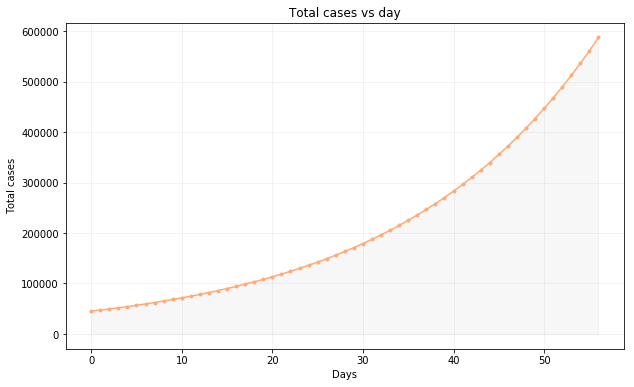

In [86]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(future_data)-7), np.array(future_data[7:]) * percentage_of_cases_in_Istanbul, color="black", alpha=0.02)
plt.fill_between(range(len(future_data)-7), np.array(future_data[7:]) * percentage_of_cases_in_Istanbul, color="black", alpha=0.01)
plt.plot(range(len(future_data)-7), np.array(future_data[7:]) * percentage_of_cases_in_Istanbul,".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("Total cases")
plt.title("Total cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot new cases vs day graph to see results of model clearly.

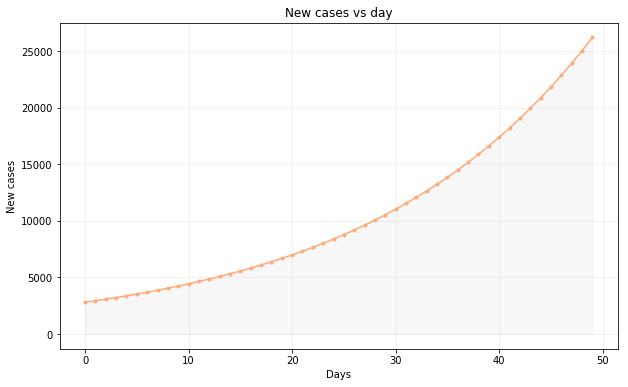

In [87]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.02)
plt.fill_between(range(len(daily_cases)-7), daily_cases[7:], color="black", alpha=0.01)
plt.plot(range(len(daily_cases)-7), daily_cases[7:],".-" , color="#FFAB78", alpha=1)
plt.xlabel("Days")
plt.ylabel("New cases")
plt.title("New cases vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of healthy covid-19 patients vs day graph to see results of simulation clearly.

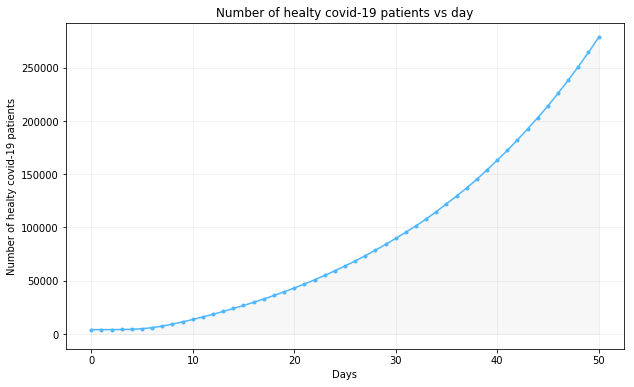

In [88]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between( range(len(healthy_patient_nums)-7), healthy_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(healthy_patient_nums)-7), healthy_patient_nums[7:],".-" , color="#4FB7FF", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of healty covid-19 patients")
plt.title("Number of healty covid-19 patients vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of deaths vs day graph to see results of simulation clearly.

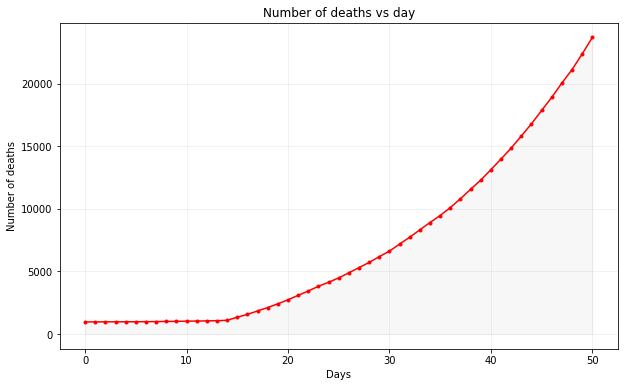

In [89]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(death_patient_nums)-7), death_patient_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(death_patient_nums)-7), death_patient_nums[7:], ".-" , color="red", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.title("Number of deaths vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of intense care percentage vs day graph to see results of simulation clearly.

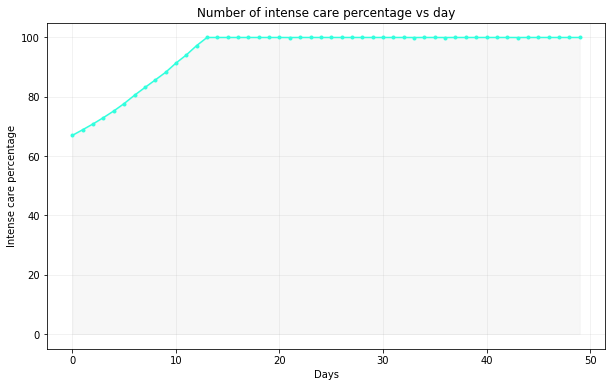

In [90]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.02)
plt.fill_between(range(len(intense_care_percets)-7), intense_care_percets[7:], color="black", alpha=0.01)
plt.plot(range(len(intense_care_percets)-7), intense_care_percets[7:], ".-" , color="#31FFDE", alpha=1)
plt.xlabel("Days")
plt.ylabel("Intense care percentage")
plt.title("Number of intense care percentage vs day")
plt.grid(alpha=0.2)
plt.show()

Plot number of patients which can not apply ICU vs day graph to see results of simulation clearly.

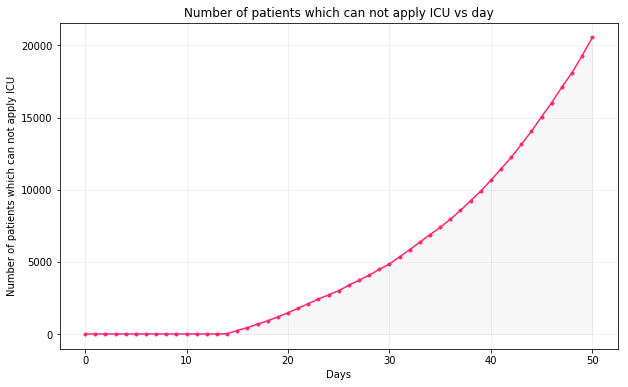

In [91]:
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.02)
plt.fill_between(range(len(non_ICU_nums)-7), non_ICU_nums[7:], color="black", alpha=0.01)
plt.plot(range(len(non_ICU_nums)-7), non_ICU_nums[7:], ".-" , color="#FF2973", alpha=1)
plt.xlabel("Days")
plt.ylabel("Number of patients which can not apply ICU")
plt.title("Number of patients which can not apply ICU vs day")
plt.grid(alpha=0.2)
plt.show()

### Results and Effects

The detailed version of the results of our project can be found on our [report](https://github.com/HUmutOzdemir/COVIDDatathon/blob/master/Report.pdf).